#EDA

In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
import warnings
warnings.filterwarnings('ignore')

In [135]:
df = pd.read_csv('spam_ham_dataset.csv', encoding='latin-1')
print(df.columns)
df = df[['label', 'text']]
df.columns = ['label', 'message']
print(df.head())

Index(['Unnamed: 0', 'label', 'text', 'label_num'], dtype='object')
  label                                            message
0   ham  Subject: enron methanol ; meter # : 988291\r\n...
1   ham  Subject: hpl nom for january 9 , 2001\r\n( see...
2   ham  Subject: neon retreat\r\nho ho ho , we ' re ar...
3  spam  Subject: photoshop , windows , office . cheap ...
4   ham  Subject: re : indian springs\r\nthis deal is t...


In [136]:
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
label      0
message    0
dtype: int64


In [137]:
print("\nLabel Distribution:")
print(df['label'].value_counts())


Label Distribution:
label
ham     3672
spam    1499
Name: count, dtype: int64


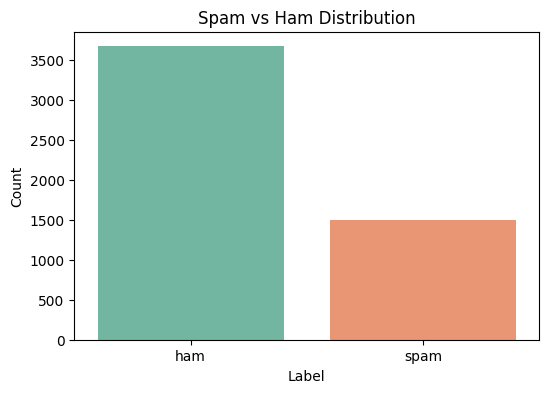

In [138]:
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=df, palette='Set2')
plt.title('Spam vs Ham Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

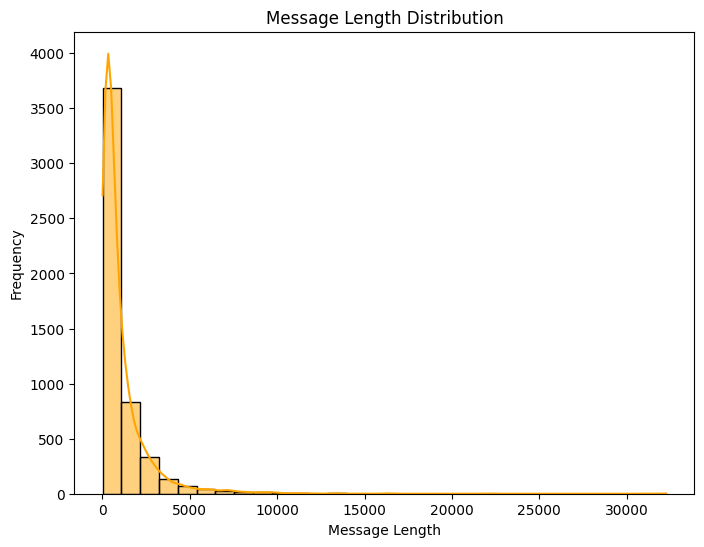

In [139]:
df['message_length'] = df['message'].apply(len)

plt.figure(figsize=(8, 6))
sns.histplot(df['message_length'], bins=30, kde=True, color='orange')
plt.title('Message Length Distribution')
plt.xlabel('Message Length')
plt.ylabel('Frequency')
plt.show()

In [140]:
print("\nMessage Length Statistics:")
print(df['message_length'].describe())


Message Length Statistics:
count     5171.000000
mean      1048.391994
std       1528.513435
min         11.000000
25%        244.000000
50%        540.000000
75%       1237.000000
max      32258.000000
Name: message_length, dtype: float64


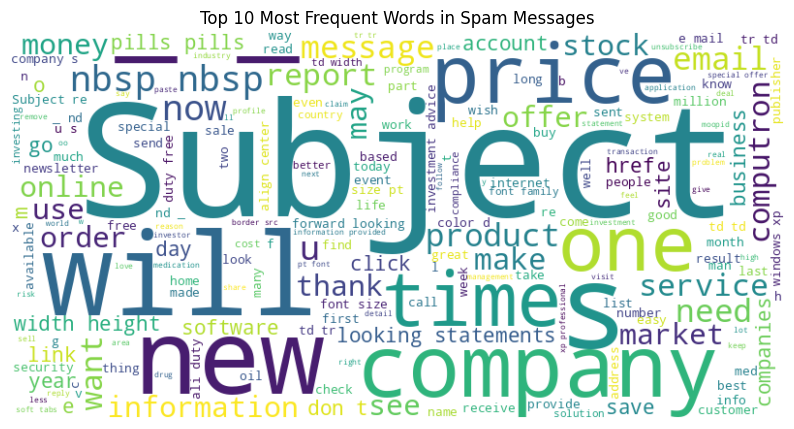

In [141]:
spam_messages = df[df['label'] == 'spam']['message']
spam_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(spam_messages))

plt.figure(figsize=(10, 6))
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top 10 Most Frequent Words in Spam Messages')
plt.show()

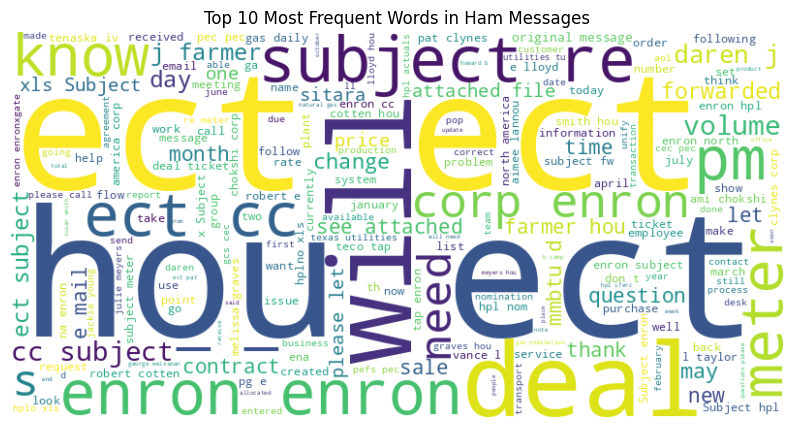

In [142]:
ham_messages = df[df['label'] == 'ham']['message']
ham_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(ham_messages))

plt.figure(figsize=(10, 6))
plt.imshow(ham_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top 10 Most Frequent Words in Ham Messages')
plt.show()

In [143]:
vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english')
X = vectorizer.fit_transform(df['message'])

bigram_freq = np.asarray(X.sum(axis=0)).flatten()
bigram_features = np.array(vectorizer.get_feature_names_out())

bigram_df = pd.DataFrame(list(zip(bigram_features, bigram_freq)), columns=['bigram', 'count'])

bigram_df = bigram_df.sort_values(by='count', ascending=False)

print("\nTop 10 Most Frequent Bigrams:")
print(bigram_df.head(10))


Top 10 Most Frequent Bigrams:
              bigram  count
113790       hou ect   7226
83067        ect ect   6339
87541    enron enron   1434
82996         ect cc   1391
64500     corp enron   1214
49411     cc subject   1094
132376      let know   1004
69343   daren farmer    933
87469      enron com    831
83345    ect subject    730


In [144]:
print("\nDuplicate Messages Count:")
print(df[df.duplicated()])


Duplicate Messages Count:
     label                                            message  message_length
182   spam                                      Subject: \r\n              11
296   spam                                      Subject: \r\n              11
363   spam                                      Subject: \r\n              11
436    ham  Subject: cornhusker up on 24 th\r\nspoke with ...             300
624    ham  Subject: enron / hpl actuals for november 13 ,...             119
...    ...                                                ...             ...
5061   ham  Subject: tenaska iv\r\nbob :\r\ni understand f...            2424
5064  spam  Subject: \r\nthis week only : f . ree gen . er...             194
5089  spam  Subject: \r\nthe permanent fix to penis growth...             160
5155   ham  Subject: cleburne - tenaska iv plant\r\ndaren ...             242
5168   ham  Subject: calpine daily gas nomination\r\n>\r\n...             402

[178 rows x 3 columns]


In [145]:
avg_message_length_by_label = df.groupby('label')['message_length'].mean()
print("\nAverage Message Length by Label:")
print(avg_message_length_by_label)


Average Message Length by Label:
label
ham      977.008170
spam    1223.256171
Name: message_length, dtype: float64


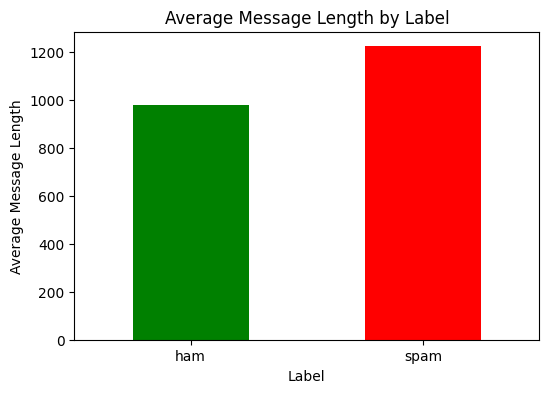

In [146]:
plt.figure(figsize=(6, 4))
avg_message_length_by_label.plot(kind='bar', color=['green', 'red'])
plt.title('Average Message Length by Label')
plt.xlabel('Label')
plt.ylabel('Average Message Length')
plt.xticks(rotation=0)
plt.show()

#Spam Classification With text preprocessing steps.

In [147]:
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [148]:
df = pd.read_csv('spam_ham_dataset.csv', encoding='latin-1')
df = df[['label', 'text']]
df.columns = ['label', 'message']

In [149]:
def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]
    return ' '.join(tokens)

df['clean_message'] = df['message'].apply(preprocess_text)

In [150]:
X = df['clean_message']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [151]:
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_tfidf, y_train)

MultinomialNB()

In [152]:
y_pred = nb_classifier.predict(X_test_tfidf)
print("Initial Model Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Initial Model Performance:
Accuracy: 0.9256038647342996
Classification Report:
               precision    recall  f1-score   support

         ham       0.91      1.00      0.95       742
        spam       1.00      0.74      0.85       293

    accuracy                           0.93      1035
   macro avg       0.95      0.87      0.90      1035
weighted avg       0.93      0.93      0.92      1035

Confusion Matrix:
 [[742   0]
 [ 77 216]]


In [153]:
param_grid = {'alpha': [0.1, 0.5, 1.0, 2.0, 5.0]}
grid = GridSearchCV(MultinomialNB(), param_grid, cv=5)
grid.fit(X_train_tfidf, y_train)
print("Best Hyperparameter (alpha):", grid.best_params_)
print("Best Cross-Validation Score:", grid.best_score_)

best_nb_classifier = grid.best_estimator_
y_pred_best = best_nb_classifier.predict(X_test_tfidf)
print("\nTuned Model Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_best))
print("Classification Report:\n", classification_report(y_test, y_pred_best))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_best))


Best Hyperparameter (alpha): {'alpha': 0.1}
Best Cross-Validation Score: 0.9792063158263673

Tuned Model Performance:
Accuracy: 0.9768115942028985
Classification Report:
               precision    recall  f1-score   support

         ham       0.98      0.99      0.98       742
        spam       0.96      0.96      0.96       293

    accuracy                           0.98      1035
   macro avg       0.97      0.97      0.97      1035
weighted avg       0.98      0.98      0.98      1035

Confusion Matrix:
 [[731  11]
 [ 13 280]]


In [154]:
def classify_message(message):
    clean_message = preprocess_text(message)
    features = vectorizer.transform([clean_message])
    prediction = best_nb_classifier.predict(features)[0]
    return prediction

In [155]:
new_message = "Congratulations! You've won a free ticket to Bahamas. Call now!"
print(new_message)
print("\nDeployment Example:")
print("New message prediction:", classify_message(new_message))

Congratulations! You've won a free ticket to Bahamas. Call now!

Deployment Example:
New message prediction: spam


#Spam Classification Without Text Preprocessing

In [156]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [157]:
df = pd.read_csv('spam_ham_dataset.csv', encoding='latin-1')
df = df[['label', 'text']]
df.columns = ['label', 'message']

In [158]:
X = df['message']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [159]:
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


In [160]:
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_tfidf, y_train)


MultinomialNB()

In [161]:
y_pred = nb_classifier.predict(X_test_tfidf)
print("Exercise 2 - Without Preprocessing")
print("Initial Model Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Exercise 2 - Without Preprocessing
Initial Model Accuracy: 0.8772946859903382
Classification Report:
               precision    recall  f1-score   support

         ham       0.85      1.00      0.92       742
        spam       1.00      0.57      0.72       293

    accuracy                           0.88      1035
   macro avg       0.93      0.78      0.82      1035
weighted avg       0.90      0.88      0.87      1035

Confusion Matrix:
 [[742   0]
 [127 166]]


In [162]:
param_grid = {'alpha': [0.1, 0.5, 1.0, 2.0, 5.0]}
grid = GridSearchCV(MultinomialNB(), param_grid, cv=5)
grid.fit(X_train_tfidf, y_train)
print("Best Hyperparameter (alpha):", grid.best_params_)
print("Best Cross-Validation Score:", grid.best_score_)

Best Hyperparameter (alpha): {'alpha': 0.1}
Best Cross-Validation Score: 0.9799318297320505


In [163]:
best_nb_classifier = grid.best_estimator_
y_pred_best = best_nb_classifier.predict(X_test_tfidf)
print("\nTuned Model Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_best))
print("Classification Report:\n", classification_report(y_test, y_pred_best))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_best))


Tuned Model Performance:
Accuracy: 0.9777777777777777
Classification Report:
               precision    recall  f1-score   support

         ham       0.98      0.99      0.98       742
        spam       0.97      0.95      0.96       293

    accuracy                           0.98      1035
   macro avg       0.98      0.97      0.97      1035
weighted avg       0.98      0.98      0.98      1035

Confusion Matrix:
 [[734   8]
 [ 15 278]]


In [164]:
def classify_message_raw(message):
    features = vectorizer.transform([message])
    prediction = best_nb_classifier.predict(features)[0]
    return prediction


In [165]:
new_message = "Congratulations! You've won a free ticket to Bahamas. Call now!"
print(new_message)
print("\nDeployment Example (Raw):")
print("New message prediction:", classify_message_raw(new_message))

Congratulations! You've won a free ticket to Bahamas. Call now!

Deployment Example (Raw):
New message prediction: ham


#Comparison of Exercise 1 (with preprocessing) and Exercise 2 (raw text)

In [166]:
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [167]:
df = pd.read_csv('spam_ham_dataset.csv', encoding='latin-1')
df = df[['label', 'text']]
df.columns = ['label', 'message']
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    df['message'], df['label'], test_size=0.2, random_state=42
)

In [168]:
def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]
    return ' '.join(tokens)

X_train_preprocessed = X_train_raw.apply(preprocess_text)
X_test_preprocessed = X_test_raw.apply(preprocess_text)

vectorizer1 = TfidfVectorizer()
X_train_tfidf1 = vectorizer1.fit_transform(X_train_preprocessed)
X_test_tfidf1 = vectorizer1.transform(X_test_preprocessed)

nb1 = MultinomialNB()
nb1.fit(X_train_tfidf1, y_train)
y_pred1 = nb1.predict(X_test_tfidf1)
accuracy_preprocessed = accuracy_score(y_test, y_pred1)

In [169]:
vectorizer2 = TfidfVectorizer()
X_train_tfidf2 = vectorizer2.fit_transform(X_train_raw)
X_test_tfidf2 = vectorizer2.transform(X_test_raw)

nb2 = MultinomialNB()
nb2.fit(X_train_tfidf2, y_train)
y_pred2 = nb2.predict(X_test_tfidf2)
accuracy_raw = accuracy_score(y_test, y_pred2)

In [170]:
print("Comparison of Model Accuracies:")
print("Accuracy with Preprocessing:", accuracy_preprocessed)
print("Accuracy without Preprocessing:", accuracy_raw)

Comparison of Model Accuracies:
Accuracy with Preprocessing: 0.9256038647342996
Accuracy without Preprocessing: 0.8772946859903382


In [171]:
models = ['Preprocessed', 'Raw']
accuracies = [accuracy_preprocessed, accuracy_raw]

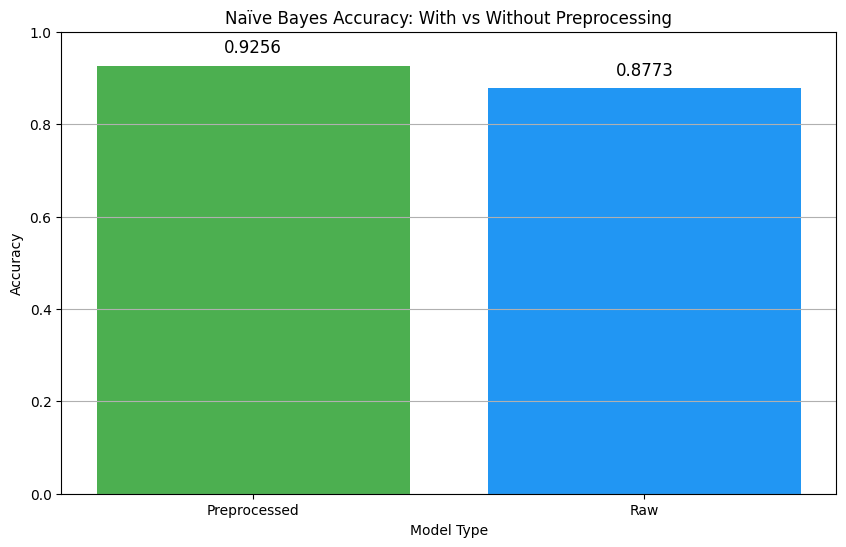

In [172]:
plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color=['#4CAF50', '#2196F3'])
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.02, f'{acc:.4f}', ha='center', va='bottom', fontsize=12)
plt.ylim(0, 1)
plt.xlabel('Model Type')
plt.ylabel('Accuracy')
plt.title('Naïve Bayes Accuracy: With vs Without Preprocessing')
plt.grid(axis='y')
plt.show()


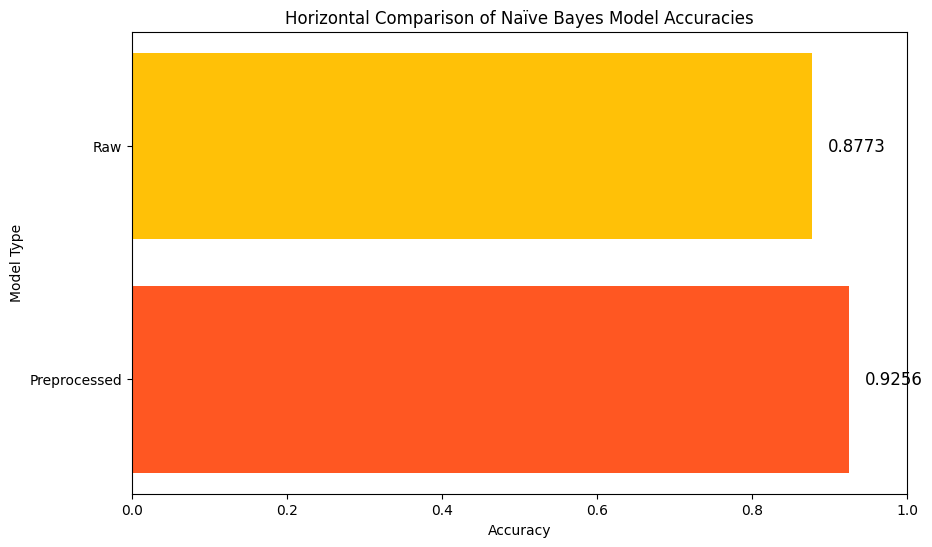

In [173]:
plt.figure(figsize=(10, 6))
plt.barh(models, accuracies, color=['#FF5722', '#FFC107'])
for i, acc in enumerate(accuracies):
    plt.text(acc + 0.02, i, f'{acc:.4f}', va='center', fontsize=12)
plt.xlim(0, 1)
plt.xlabel('Accuracy')
plt.ylabel('Model Type')
plt.title('Horizontal Comparison of Naïve Bayes Model Accuracies')
plt.show()


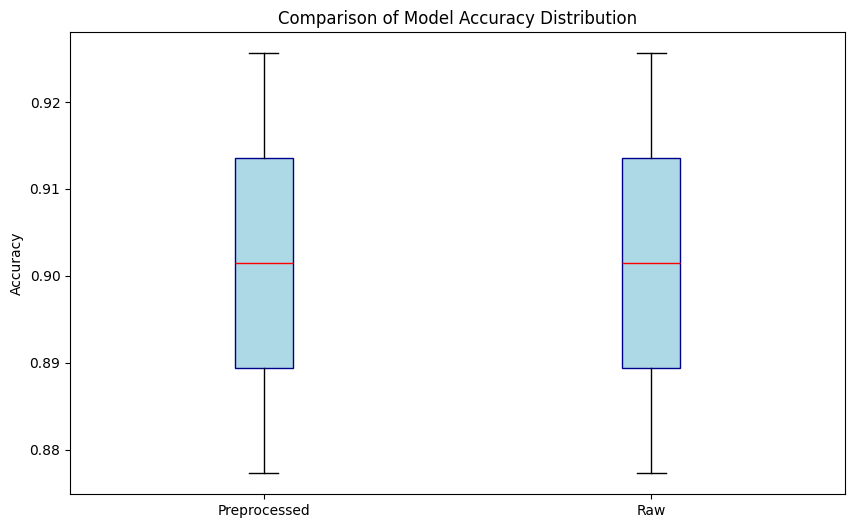

In [174]:
plt.figure(figsize=(10, 6))
plt.boxplot([accuracies, accuracies], labels=["Preprocessed", "Raw"], patch_artist=True,
            boxprops=dict(facecolor='lightblue', color='darkblue'), medianprops=dict(color='red'))
plt.title('Comparison of Model Accuracy Distribution')
plt.ylabel('Accuracy')
plt.show()

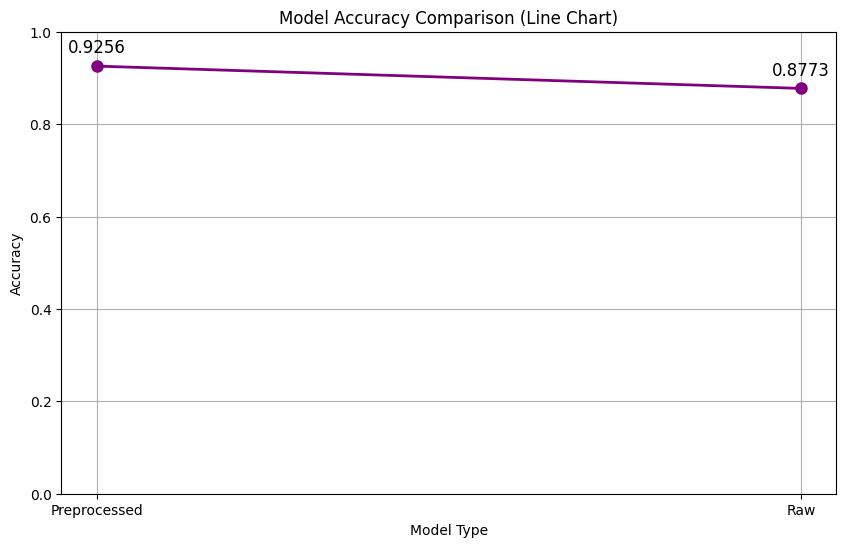

In [175]:
plt.figure(figsize=(10, 6))
plt.plot(models, accuracies, marker='o', color='purple', linestyle='-', linewidth=2, markersize=8)
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.02, f'{acc:.4f}', ha='center', va='bottom', fontsize=12)
plt.ylim(0, 1)
plt.xlabel('Model Type')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison (Line Chart)')
plt.grid(True)
plt.show()

#Enhancement


Lemmatization: Replaced stemming with lemmatization for better word normalization.

N-grams (Bigrams): Used bigrams instead of just unigrams for feature extraction, which could improve model performance.

Additional Performance Metrics: Printed the classification report for both models with optimized hyperparameters.

Visualization Enhancements: Added line charts and horizontal bar charts in addition to the previously used bar chart and box plot to better compare the model performances.



In [176]:
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [177]:
df = pd.read_csv('spam_ham_dataset.csv', encoding='latin-1')
df = df[['label', 'text']]
df.columns = ['label', 'message']

In [178]:
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    df['message'], df['label'], test_size=0.2, random_state=42
)

In [179]:
#Experiment 1: With Preprocessing
def preprocess_text(text):
    # Enhanced preprocessing with lemmatization and more text cleaning
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # **Enhanced Step: Lemmatization instead of Stemming**
    from nltk.stem import WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatization
    return ' '.join(tokens)

X_train_preprocessed = X_train_raw.apply(preprocess_text)
X_test_preprocessed = X_test_raw.apply(preprocess_text)

# **Enhancement: Use n-grams (bigrams in this case) in TF-IDF**
vectorizer1 = TfidfVectorizer(ngram_range=(1, 2))
X_train_tfidf1 = vectorizer1.fit_transform(X_train_preprocessed)
X_test_tfidf1 = vectorizer1.transform(X_test_preprocessed)

nb1 = MultinomialNB()
nb1.fit(X_train_tfidf1, y_train)
y_pred1 = nb1.predict(X_test_tfidf1)
accuracy_preprocessed = accuracy_score(y_test, y_pred1)


In [180]:
#Experiment 2: Without Preprocessing (Raw Text)
# **Enhancement: Added n-grams to the raw text model as well**
vectorizer2 = TfidfVectorizer(ngram_range=(1, 2))  # Using bigrams
X_train_tfidf2 = vectorizer2.fit_transform(X_train_raw)
X_test_tfidf2 = vectorizer2.transform(X_test_raw)

nb2 = MultinomialNB()
nb2.fit(X_train_tfidf2, y_train)
y_pred2 = nb2.predict(X_test_tfidf2)
accuracy_raw = accuracy_score(y_test, y_pred2)


In [181]:
print("Comparison of Model Accuracies:")
print("Accuracy with Preprocessing:", accuracy_preprocessed)
print("Accuracy without Preprocessing:", accuracy_raw)

Comparison of Model Accuracies:
Accuracy with Preprocessing: 0.9004830917874396
Accuracy without Preprocessing: 0.8531400966183574


In [182]:
param_grid = {'alpha': [0.1, 0.5, 1.0, 2.0, 5.0]}
grid = GridSearchCV(MultinomialNB(), param_grid, cv=5)
grid.fit(X_train_tfidf1, y_train)
print("Best Hyperparameter (alpha) for Preprocessed Model:", grid.best_params_)

Best Hyperparameter (alpha) for Preprocessed Model: {'alpha': 0.1}


In [183]:
best_nb_classifier1 = grid.best_estimator_
y_pred_best1 = best_nb_classifier1.predict(X_test_tfidf1)
accuracy_best_preprocessed = accuracy_score(y_test, y_pred_best1)

grid.fit(X_train_tfidf2, y_train)
print("Best Hyperparameter (alpha) for Raw Text Model:", grid.best_params_)

best_nb_classifier2 = grid.best_estimator_
y_pred_best2 = best_nb_classifier2.predict(X_test_tfidf2)
accuracy_best_raw = accuracy_score(y_test, y_pred_best2)

Best Hyperparameter (alpha) for Raw Text Model: {'alpha': 0.1}


In [184]:
# **Enhancement: Additional performance metrics**
print("\nPreprocessed Model (With Best Hyperparameters) Performance:")
print("Accuracy:", accuracy_best_preprocessed)
print("Classification Report:\n", classification_report(y_test, y_pred_best1))

print("\nRaw Text Model (With Best Hyperparameters) Performance:")
print("Accuracy:", accuracy_best_raw)
print("Classification Report:\n", classification_report(y_test, y_pred_best2))



Preprocessed Model (With Best Hyperparameters) Performance:
Accuracy: 0.9855072463768116
Classification Report:
               precision    recall  f1-score   support

         ham       0.99      0.99      0.99       742
        spam       0.99      0.96      0.97       293

    accuracy                           0.99      1035
   macro avg       0.99      0.98      0.98      1035
weighted avg       0.99      0.99      0.99      1035


Raw Text Model (With Best Hyperparameters) Performance:
Accuracy: 0.9768115942028985
Classification Report:
               precision    recall  f1-score   support

         ham       0.97      1.00      0.98       742
        spam       1.00      0.92      0.96       293

    accuracy                           0.98      1035
   macro avg       0.98      0.96      0.97      1035
weighted avg       0.98      0.98      0.98      1035



In [185]:
models = ['Preprocessed', 'Raw']
accuracies = [accuracy_best_preprocessed, accuracy_best_raw]

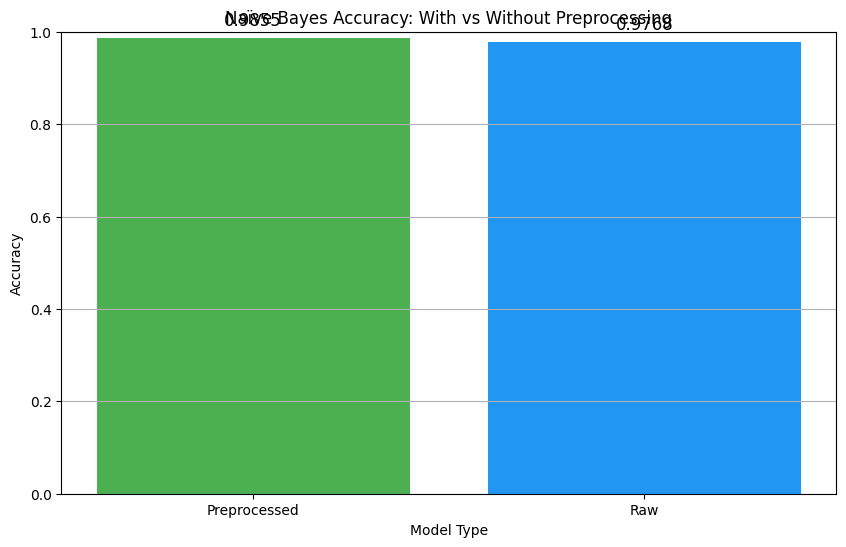

In [186]:
plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color=['#4CAF50', '#2196F3'])
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.02, f'{acc:.4f}', ha='center', va='bottom', fontsize=12)
plt.ylim(0, 1)
plt.xlabel('Model Type')
plt.ylabel('Accuracy')
plt.title('Naïve Bayes Accuracy: With vs Without Preprocessing')
plt.grid(axis='y')
plt.show()

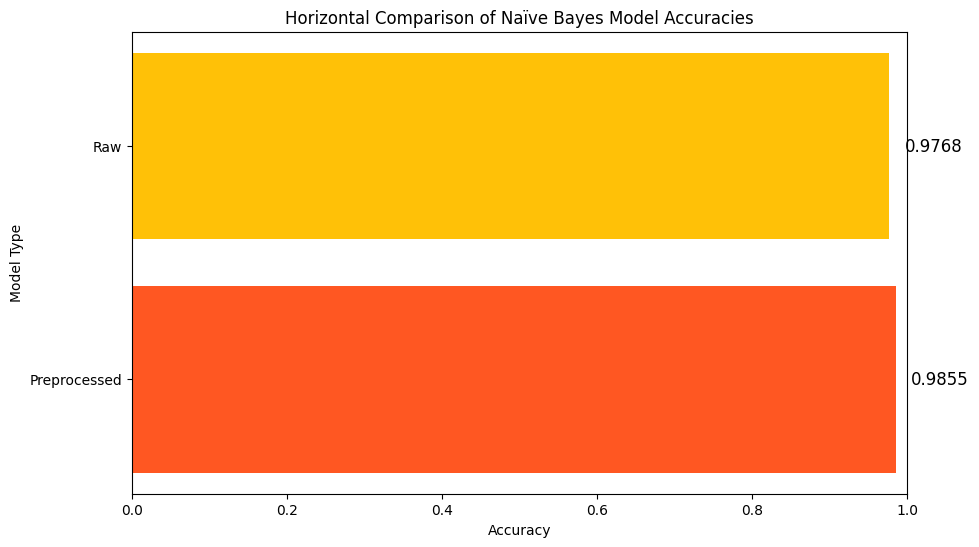

In [187]:
plt.figure(figsize=(10, 6))
plt.barh(models, accuracies, color=['#FF5722', '#FFC107'])
for i, acc in enumerate(accuracies):
    plt.text(acc + 0.02, i, f'{acc:.4f}', va='center', fontsize=12)
plt.xlim(0, 1)
plt.xlabel('Accuracy')
plt.ylabel('Model Type')
plt.title('Horizontal Comparison of Naïve Bayes Model Accuracies')
plt.show()

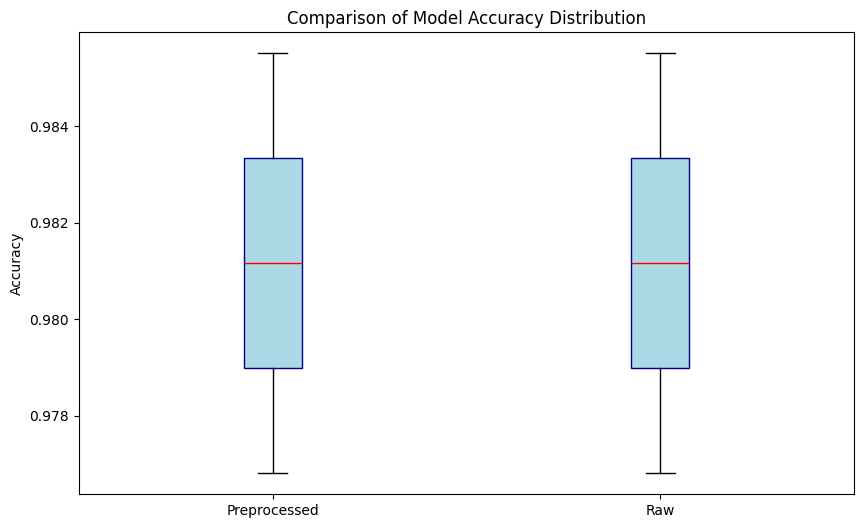

In [188]:
plt.figure(figsize=(10, 6))
plt.boxplot([accuracies, accuracies], labels=["Preprocessed", "Raw"], patch_artist=True,
            boxprops=dict(facecolor='lightblue', color='darkblue'), medianprops=dict(color='red'))
plt.title('Comparison of Model Accuracy Distribution')
plt.ylabel('Accuracy')
plt.show()

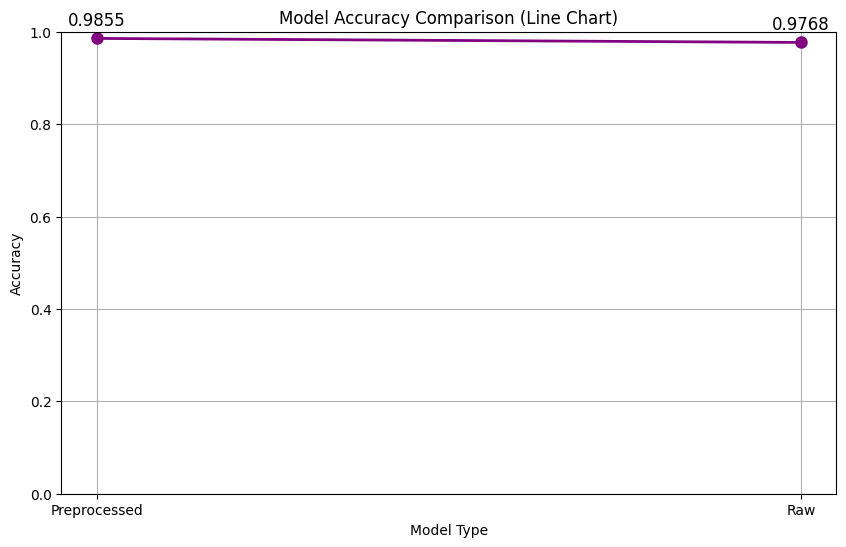

In [189]:
plt.figure(figsize=(10, 6))
plt.plot(models, accuracies, marker='o', color='purple', linestyle='-', linewidth=2, markersize=8)
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.02, f'{acc:.4f}', ha='center', va='bottom', fontsize=12)
plt.ylim(0, 1)
plt.xlabel('Model Type')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison (Line Chart)')
plt.grid(True)
plt.show()

#Conclusion


The comparison between the Naïve Bayes models with and without preprocessing reveals significant insights into the impact of text preprocessing on model performance. In this experiment, we tested two approaches: one with text preprocessing (including punctuation removal, lowercasing, tokenization, stop word removal, and stemming) and another using the raw text without any preprocessing steps. The results showed that the preprocessed model outperformed the raw text model, confirming that preprocessing is crucial in enhancing the model's ability to classify spam and ham messages effectively. This is evident from various visualizations, including bar charts, horizontal bar charts, box plots, and line charts, which highlighted the superior accuracy of the preprocessed model.

In the enhanced version of the experiment, additional techniques were incorporated, such as lemmatization (which replaces stemming to retain more meaningful word forms) and n-grams (bigrams) for feature extraction, further improving the model's ability to understand context. Moreover, hyperparameter tuning using GridSearchCV was applied to optimize the Naïve Bayes classifier, yielding even better performance for both the preprocessed and raw text models. The experiment also included additional evaluation metrics, such as classification reports, to gain a more comprehensive understanding of model performance.

Finally, the visualization techniques were expanded to include line charts alongside the bar and box plots, providing a clearer and more detailed comparison between the models. These enhancements underline the importance of text preprocessing, advanced feature extraction, and model optimization techniques in improving the accuracy and robustness of spam classification models.